# All data analysis

In [139]:
import pandas as pd
import numpy as np

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [141]:
import shap
shap.initjs()

In [142]:
data = pd.read_csv('all_data.csv', low_memory=False)

In [143]:
data.shape

(40938, 16)

In [144]:
data.dtypes

age                    int64
job                   object
marital               object
education             object
default               object
housing               object
loan                  object
pdays                  int64
previous               int64
poutcome              object
emp.var.rate         float64
cons.price.idx       float64
cons.conf.idx        float64
y                      int64
test_control_flag     object
was_contacted          int64
dtype: object

In [145]:
# Convert all 'object' type columns to 'category'
object_columns = data.select_dtypes(include=['object']).columns
data[object_columns] = data[object_columns].astype('category')

In [146]:
cat_cols = ['was_contacted', 'y']
data[cat_cols] = data[cat_cols].astype('category')

In [147]:
data.dtypes

age                     int64
job                  category
marital              category
education            category
default              category
housing              category
loan                 category
pdays                   int64
previous                int64
poutcome             category
emp.var.rate          float64
cons.price.idx        float64
cons.conf.idx         float64
y                    category
test_control_flag    category
was_contacted        category
dtype: object

In [148]:
cat_var = data.select_dtypes(include=['category']).columns.tolist()
con_var = data.select_dtypes(include=['float64', 'int64']).columns.tolist()

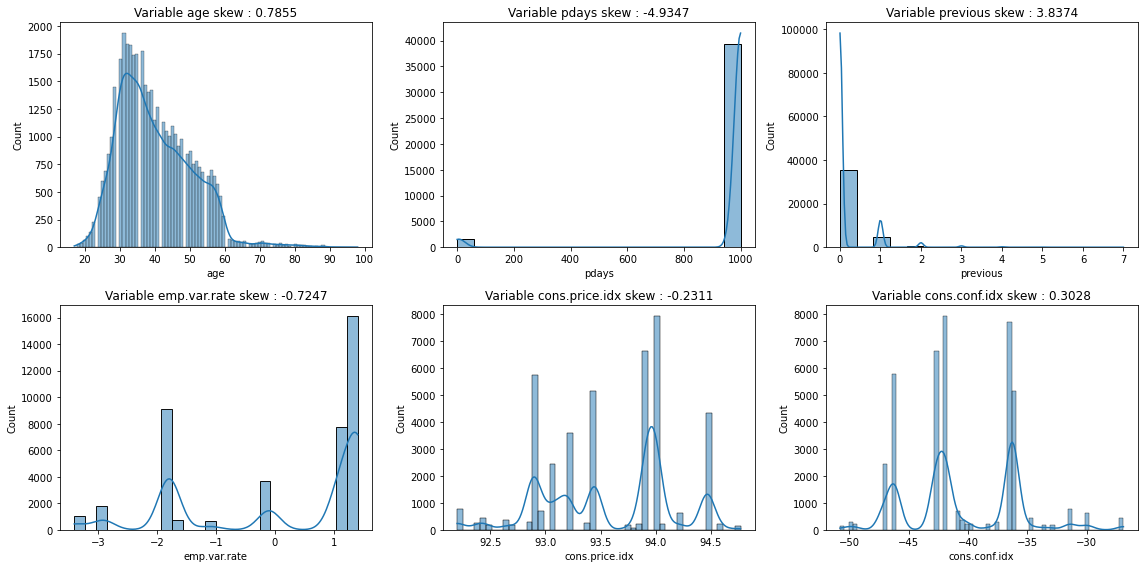

In [149]:
def con_plot(var):
    fig, ax = plt.subplots(int(np.ceil(len(con_var)/3)), 3, figsize=(16,8))
    ax = ax.flatten()
    i = 0
    for col in var:
        skew = data[col].skew()
        sns.histplot(data[col], kde=True, ax=ax[i])  # Use histplot
        ax[i].set_title("Variable %s skew : %.4f"%(col, skew))
        i += 1
    plt.tight_layout()
    plt.show()

con_plot(con_var)


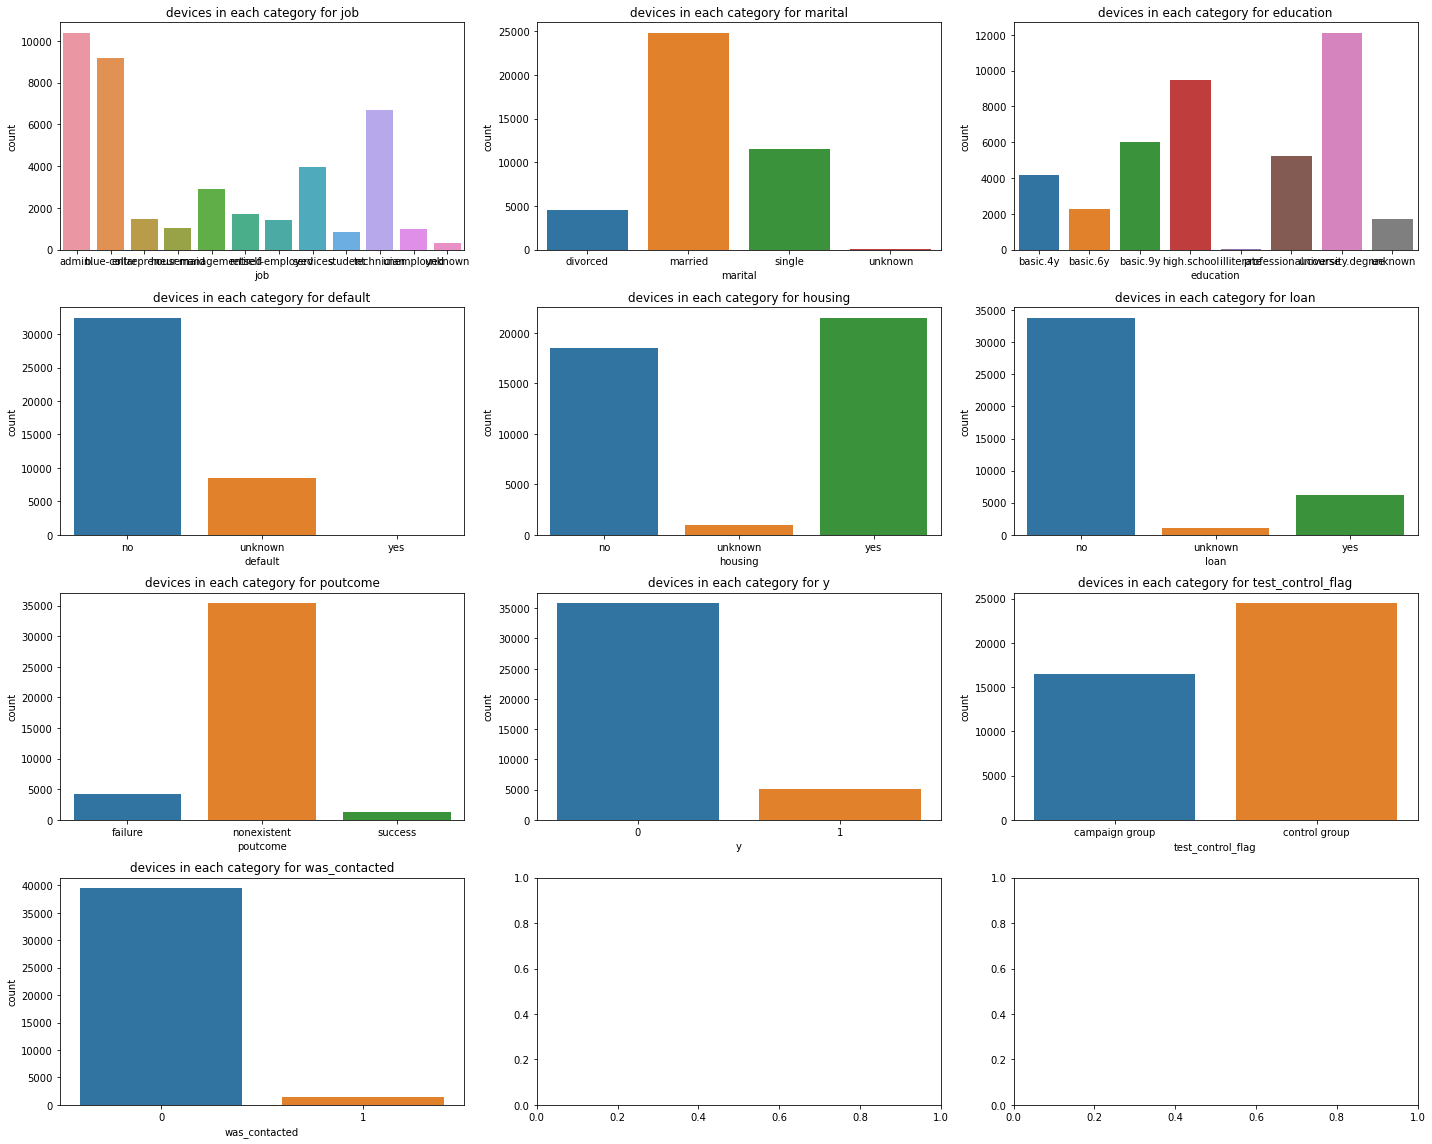

In [160]:
def cat_plot(var):
    fig, ax = plt.subplots(int(np.ceil(len(var)/3)), 3, figsize=(20,16))
    ax = ax.flatten()
    i = 0
    for col in var:
        sns.countplot(data[col], ax=ax[i])
        ax[i].set_title("devices in each category for %s"%(col))
        i+=1
    plt.tight_layout()
    plt.show()
    
cat_plot(cat_var)

# 2. Preparing data for algorithm

In [161]:
category_columns = data.select_dtypes(include=['category']).columns.tolist()

In [162]:
category_columns.remove('y')

In [163]:
category_columns

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'poutcome',
 'test_control_flag',
 'was_contacted']

In [164]:
prepared_data_all = pd.get_dummies(data, columns = category_columns)

In [165]:
prepared_data_all.shape

(40938, 47)

In [166]:
prepared_data_all = prepared_data_all.drop(columns = ['job_unknown', 'marital_unknown', 'education_unknown', 'default_unknown', \
                                  'housing_unknown', 'loan_unknown', 'poutcome_nonexistent'])

In [167]:
all_columns = prepared_data_all.columns.tolist()

In [168]:
all_columns.remove('y')

In [169]:
all_columns

['age',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'education_basic.4y',
 'education_basic.6y',
 'education_basic.9y',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'default_no',
 'default_yes',
 'housing_no',
 'housing_yes',
 'loan_no',
 'loan_yes',
 'poutcome_failure',
 'poutcome_success',
 'test_control_flag_campaign group',
 'test_control_flag_control group',
 'was_contacted_0',
 'was_contacted_1']

### 3. Train & test split

In [170]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [171]:
X = prepared_data_all[all_columns]

In [172]:
y = prepared_data_all['y']

In [173]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

## Create a logistic regression model

In [190]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', penalty='none', max_iter=10000)  # Increase max_iter value?

**lbfgs** stands for: "Limited-memory Broyden–Fletcher–Goldfarb–Shanno Algorithm". It is one of the solvers' algorithms provided by Scikit-Learn Library.

The term limited-memory simply means it stores only a few vectors that represent the gradients approximation implicitly.

It has better convergence on relatively small datasets.

In [191]:
# other solvers: saga, sag, lbfgs

In [192]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000, penalty='none')

### Hyperparameter tuning

In [193]:
# Hyperparameter tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs', 'sag', 'saga']
}

### Random Search

### Predict test data

In [194]:
y_pred = model.predict(X_test)

In [195]:
print("Predicted value: ", y_pred[:10])
print("Actual value: ", y_test[:10])

Predicted value:  [0 0 0 0 0 0 0 0 0 0]
Actual value:  7277     0
19357    0
27845    0
10017    0
24185    0
24116    0
17556    0
31296    0
40660    1
12239    0
Name: y, dtype: category
Categories (2, int64): [0, 1]


In [196]:
from sklearn.metrics import accuracy_score
accuracy_log_reg = accuracy_score(y_pred = y_pred, y_true = y_test)
print(f'Accuracy of the model Logistic Regression is {accuracy_log_reg*100:.2f}%')

Accuracy of the model Logistic Regression is 88.26%


### Expected campaign lift

In [197]:
percentage = 51.54 # from DataSeparationScript
expected_lift = ((accuracy_log_reg*100/percentage)-1)*100
print(f"Expected campaign lift is {expected_lift:.2f}%")

Expected campaign lift is 71.25%


# Feature importance

<AxesSubplot:ylabel='Feature'>

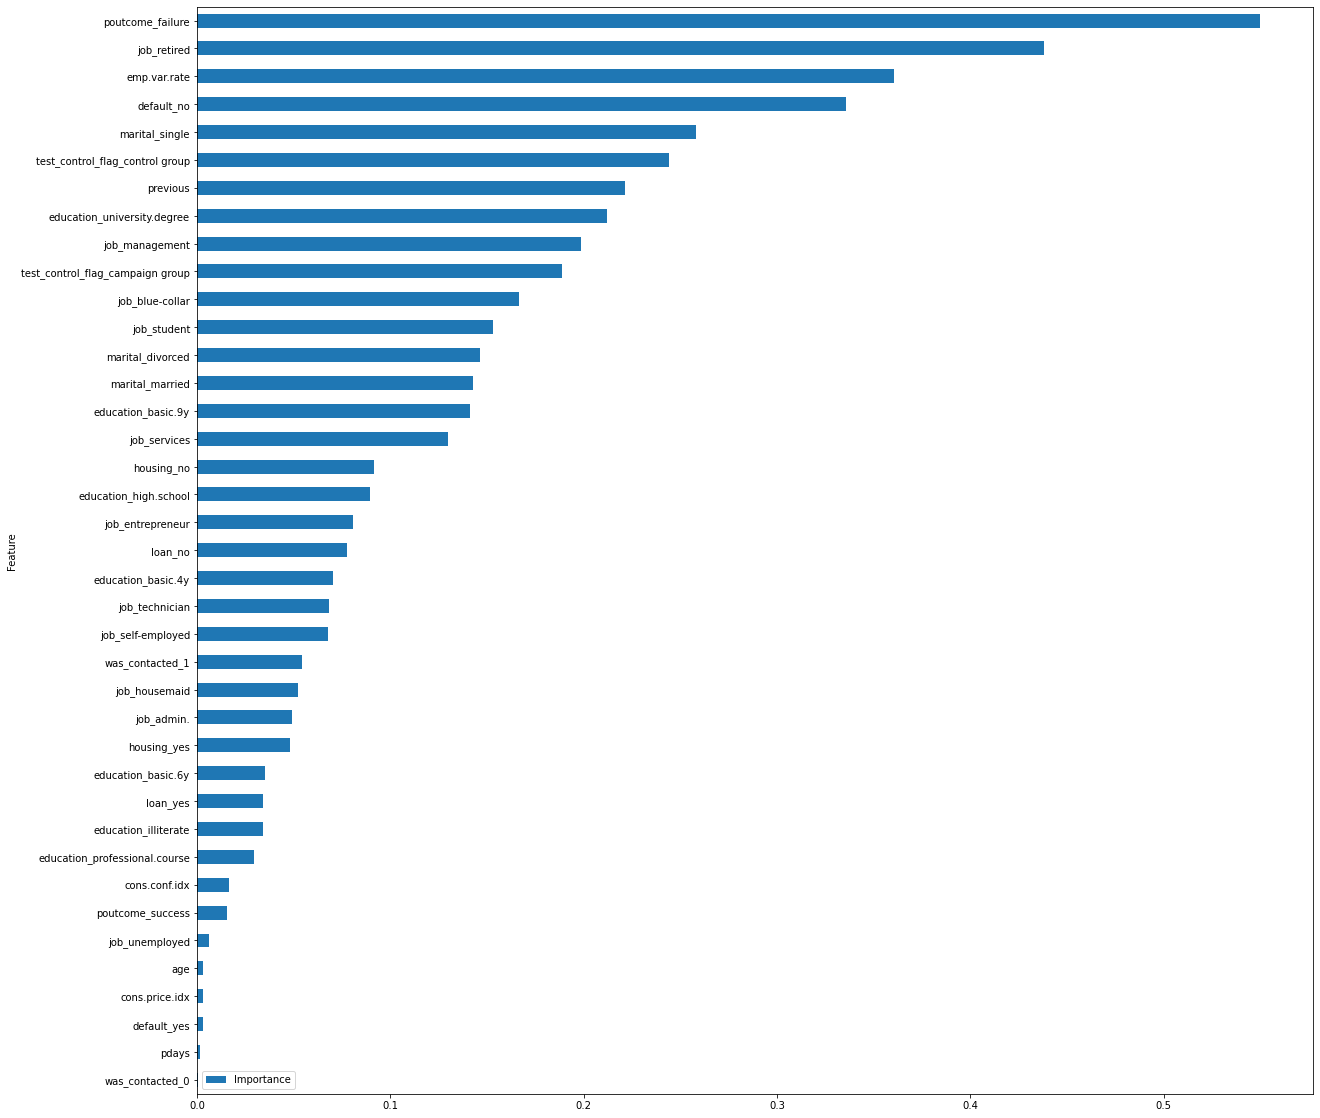

In [198]:
coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(20, 20))

## ROC graph

ROC (Receiver Operating Characteristic) graphs are a graphical representation used to assess the performance of binary classification models, especially in the context of diagnostic tests, machine learning models, and other areas where classification is important. ROC graphs illustrate the trade-off between the true positive rate (sensitivity) and the false positive rate (1-specificity) for different thresholds set on the predicted probabilities or scores generated by a classification model.

Here's how an ROC graph works:

- **True Positive Rate (Sensitivity):** This is the ratio of correctly predicted positive instances to all actual positive instances. It's also called recall or hit rate.

- **False Positive Rate (1-Specificity):** This is the ratio of incorrectly predicted positive instances to all actual negative instances. It's also called the false alarm rate.

An ROC graph is created by plotting the true positive rate against the false positive rate at various threshold values. Each point on the ROC graph represents the performance of the model at a specific threshold. The diagonal line from the bottom-left corner to the top-right corner represents random guessing, while a curve that approaches the top-left corner represents a better-performing model.

In general, a classification model's performance is considered better if its ROC curve is closer to the top-left corner, indicating a higher true positive rate for a given false positive rate. The area under the ROC curve (AUC-ROC) is a commonly used metric to quantify the overall performance of a binary classification model. A model with an AUC-ROC value closer to 1.0 indicates better discrimination between the two classes.

ROC graphs provide a useful visual tool for comparing different classification models and selecting an appropriate threshold for making predictions based on the specific balance between false positives and true positives that is desired for a given application.

### ROC

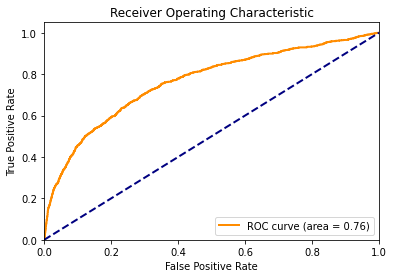

AUC: 0.7629417285839457


In [199]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import roc_auc_score

y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)

print("AUC:", auc)

- AUC around 0.5: This suggests that the model's predictions are not much better than random guessing. It might mean that the model is not performing well.
- AUC above 0.7: This is considered decent and indicates that the model has some ability to discriminate between the classes. It suggests that the model is performing better than random guessing.
- AUC above 0.8: This is generally considered to be good performance. The model is distinguishing between the classes quite well.
- AUC above 0.9: This indicates excellent performance. The model is making highly accurate predictions.

## Explainable AI - SHAP values

In [187]:
explainer = shap.Explainer(model, X_train)
# Explain individual predictions
shap_values = explainer(X)

### Waterfall plot

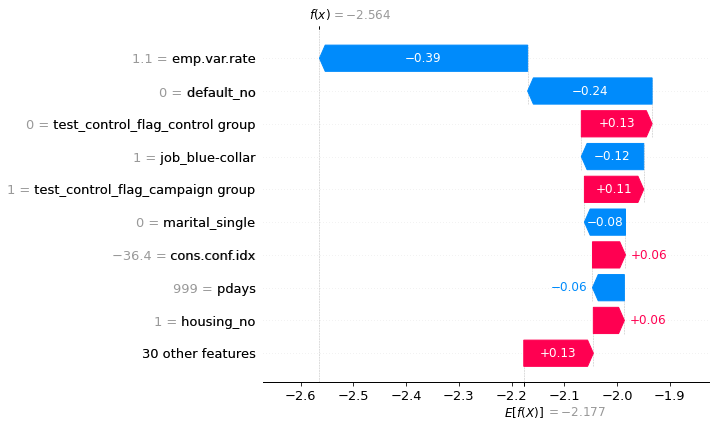

In [189]:
# Index of the instance you want to explain
instance_idx = 2

# Create a summary plot (waterfall plot) for the instance
shap.plots.waterfall(shap_values[instance_idx], max_display=10)

In [129]:
shap.plots.force(shap_values[0:100])

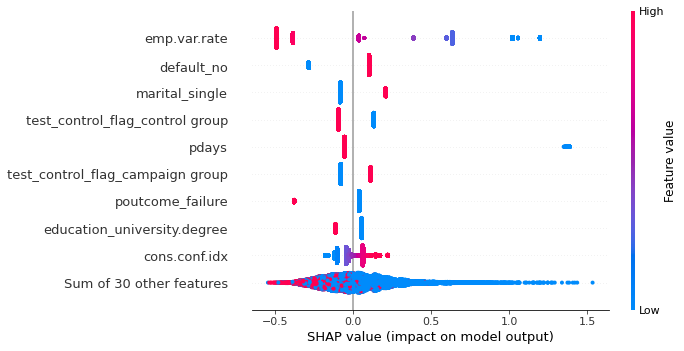

In [130]:
shap.plots.beeswarm(shap_values)

## Other models

### XGBoost

In [132]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [133]:
# Create XGBoost classifier
model = xgb.XGBClassifier()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

In [137]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of the XGBoost model is: {accuracy*100:.2f}%')

Accuracy of the XGBoost model is: 88.12%


## Random Forest clasiffier

In [87]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfcpredictions = rfc.predict(X_test)
print("Predicted value: ", rfcpredictions[:10])
print("Actual value: ", y_test[:10])

Predicted value:  [0 0 0 0 0 0 0 0 1 0]
Actual value:  7277     0
19357    0
27845    0
10017    0
24185    0
24116    0
17556    0
31296    0
40660    1
12239    0
Name: y, dtype: category
Categories (2, int64): [0, 1]


In [88]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred = rfcpredictions, y_true = y_test)
print(f'Accuracy of the Random Forest Classifier model is {accuracy*100:.2f}%')

Accuracy of the Random Forest Classifier model is 86.20%


### SVC (support Vector Classifier)

In [89]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
svcpredictions = svc.predict(X_test)
print("Predicted value: ", svcpredictions[:10])
print("Actual value: ", y_test[:10])

Predicted value:  [0 0 0 0 0 0 0 0 0 0]
Actual value:  7277     0
19357    0
27845    0
10017    0
24185    0
24116    0
17556    0
31296    0
40660    1
12239    0
Name: y, dtype: category
Categories (2, int64): [0, 1]


In [90]:
accuracy = accuracy_score(y_pred = svcpredictions, y_true = y_test)
print(f'Accuracy of the SVC model is {accuracy*100:.2f}%')

Accuracy of the SVC model is 88.25%


### Decision Tree Classifier

In [91]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)
dtcprediction = dtc.predict(X_test)
print("Predicted value: ", dtcprediction[:10])
print("Actual value: ", y_test[:10])

Predicted value:  [0 0 0 0 0 0 0 0 1 0]
Actual value:  7277     0
19357    0
27845    0
10017    0
24185    0
24116    0
17556    0
31296    0
40660    1
12239    0
Name: y, dtype: category
Categories (2, int64): [0, 1]


In [88]:
accuracy = accuracy_score(y_pred = dtcprediction, y_true = y_test)
print(f'Accuracy of the Decision Tree Classifier model is {accuracy*100:.2f}%')

Accuracy of the Decision Tree Classifier model is 82.69%
